In [1]:
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.colors import to_rgba
from shapely.geometry import Point, Polygon
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from scipy import interpolate
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
# import telecommunication data for trentino area
df_telcom_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG_Assignment/data/Internet_traffic_activity.csv',header=None)  
# change column names to meaningful values
df_telcom_raw.columns =['Square_id','Timestamp','Internet_traffic_activity']
# copy raw data to processed (copies only the reference to the object) 
df_telcom_processed = df_telcom_raw.copy()
# drop duplicates found in the dataset
df_telcom_processed.drop_duplicates(inplace=True)
# convert timestamp column to datetime type
df_telcom_processed.Timestamp = pd.to_datetime(df_telcom_processed.Timestamp, format='%Y-%m-%d %H:%M')
# remove outliers
df_telcom_processed = df_telcom_processed[df_telcom_processed.Internet_traffic_activity < 1000]
df_telcom_processed = df_telcom_processed[np.abs(df_telcom_processed.Internet_traffic_activity-df_telcom_processed.Internet_traffic_activity.mean()) <= (2*df_telcom_processed.Internet_traffic_activity.std())]
print(df_telcom_processed.dtypes)
df_telcom_processed

Square_id                             int64
Timestamp                    datetime64[ns]
Internet_traffic_activity           float64
dtype: object


,Square_id,Timestamp,Internet_traffic_activity
0,10000,2013-12-01 00:00:00,9.381368
1,10000,2013-12-01 01:00:00,11.966050
2,10000,2013-12-01 02:00:00,10.588980
3,10000,2013-12-01 03:00:00,8.662089
4,10000,2013-12-01 04:00:00,7.491499
...,...,...,...
4646414,9999,2013-12-31 19:00:00,33.811344
4646415,9999,2013-12-31 20:00:00,32.427682
4646416,9999,2013-12-31 21:00:00,34.441008
4646417,9999,2013-12-31 22:00:00,32.575771


In [3]:
# daily internet activity
df_univariate = df_telcom_processed.groupby(['Timestamp'])['Internet_traffic_activity'].mean()
df_univariate = pd.DataFrame({'Internet_traffic_activity' : df_univariate.values})

df_univariate

,Internet_traffic_activity
0,10.791643
1,9.016772
2,8.025946
3,7.165185
4,6.770193
...,...
739,22.168585
740,22.217270
741,21.223424
742,20.838725


In [4]:
df_univariate.describe()

,Internet_traffic_activity
count,744.000000
mean,12.398814
std,4.124867
min,6.408956
25%,9.398740
50%,11.810967
75%,14.665739
max,24.140839


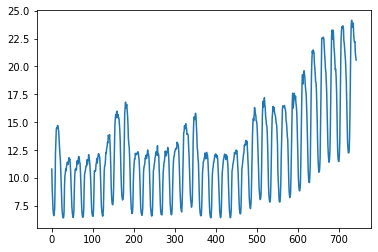

In [5]:
df_univariate['Internet_traffic_activity'].plot()

We can observe from the above plot that we should take into account seasonality and possible trend. This needs further investigation with Dickey–Fuller

In [6]:
# ADF Test
result = adfuller(df_univariate['Internet_traffic_activity'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: 2.22731243877167
n_lags: 0.9989042360785598
p-value: 0.9989042360785598
Critial Values:
   1%, -3.4394269973845657
Critial Values:
   5%, -2.8655458544300387
Critial Values:
   10%, -2.568903174551249


Do not reject the null hypothesis. So, the time series is non-stationary.

In [7]:
# split univariate dataset to train and test dataset
train_length = int(len(df_univariate['Internet_traffic_activity'].values)*0.8)

train_values = df_univariate['Internet_traffic_activity'].values[:train_length]
test_values = df_univariate['Internet_traffic_activity'].values[train_length:]
print(len(train_values)+len(test_values))
print(len(df_univariate['Internet_traffic_activity'].values))

744
744


In [8]:
class StatisticalModel:
  '''
  Perform statistical modelling using ARIMA and SARIMA models
  '''
  def __init__(self, X=None, y_test=None, start_p=None, start_q=None,
                test='adf',max_p=None, max_q=None, m=None,
                start_P=None, seasonal=False,
                d=None, D=None, trace=True, 
                error_action='ignore', suppress_warnings=True, 
                stepwise=True):
    self.X = X
    self.y_test = y_test
    self.start_p = start_p
    self.start_q = start_q
    self.test = test
    self.max_p = max_p
    self.max_q = max_q
    self.m = m
    self.start_P = start_P
    self.seasonal = seasonal
    self.d = d
    self.D = D
    self.trace = trace
    self.error_action = error_action
    self.suppress_warnings = suppress_warnings
    self.stepwise = True
      
  # fit arima/sarima model
  def model_arima(self):
    '''
    Chooses the optimum ARIMA/SARIMA parameters and 
    performs the ARIMA/SARIMA modelling.

    Returns: ARIMA/SARIMA model
    '''
    
    self.model = pm.auto_arima(y = self.X, start_p = self.start_p, start_q = self.start_q,
                          test = self.test, max_p = self.max_p, max_q = self.max_q,
                          m = self.m, start_P = self.start_P,
                          seasonal = self.seasonal, d = self.d, 
                          D = self.D, trace = self.trace,
                          error_action = self.error_action,  
                          suppress_warnnigs = self.suppress_warnings, 
                          stepwise = self.stepwise)
    return self.model

  # produce model summary
  def print_model_summary(self):
    print(self.model.summary())

  # plot model diagnostics
  def plot_diagnostics(self):
    self.model.plot_diagnostics(figsize=(7,5))
    plt.show()

  # plot predicted along with actual values
  def plot_predicted_actual_values(self):
    index_of_fc = np.arange(len(train_values),
                            len(train_values)+self.no_of_samples)

    # make series for plotting purpose
    fc_series = pd.Series(self.y_pred, index=index_of_fc)
    actual_values = np.concatenate((self.X ,self.y_test), axis=0)
    plt.plot(actual_values)
    plt.plot(fc_series, color='darkgreen')

    plt.title("Forecast of Internet Usage")
    plt.show()

  # make predictions
  def make_prediction(self,no_of_samples):
    self.no_of_samples = no_of_samples
    self.y_pred = self.model.predict(no_of_samples)
    return self.y_pred
  
  #  output the metrics
  def print_metrics(self):
      print('Mean Absolute Error (test):', metrics.mean_absolute_error(self.y_test, self.y_pred))
      print('R squared (test): ' + str(metrics.r2_score(self.y_test, self.y_pred)))
      print('\n')

  # print summary of the model
  def print_model_summary(self):
    return self.model.summary()

  # setters methods
  def set_X(self,X):
      self.X = X
  def set_seasonal(self,seasonal):
      self.seasonal = seasonal   
  def set_max_p(self,max_p):  
      self.max_p = max_p
  def set_max_q(self,max_q):
      self.max_q = max_q
  def set_m(self,m):
      self.m = m

  # getters methods
  def get_y_pred(self):
    return self.y_pred
  def get_max_q(self):
    return self.max_q
  def get_start_q(self):
    return self.start_q

  def __str__(self):
    if isinstance(self.model,pm.arima.ARIMA):
      return str(self.print_model_summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=953.528, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1485.320, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=959.919, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1148.959, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1483.412, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=945.112, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1011.683, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=850.893, Time=0.99 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=854.079, Time=1.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=807.873, Time=1.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=946.144, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=854.689, Time=1.64 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=805.372, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=944.1

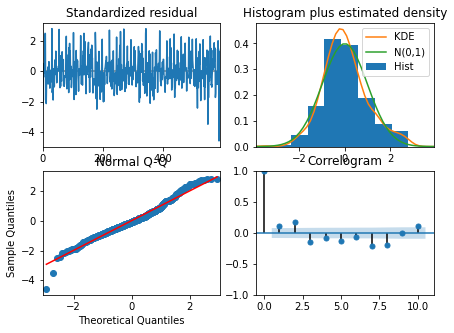

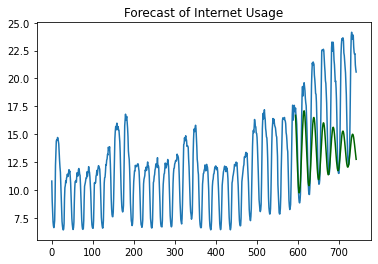

Mean Absolute Error (test): 4.062259903166626
R squared (test): -0.22947709013209194




In [9]:
# initialise statistical model object
object_arima = StatisticalModel(train_values, test_values, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=1,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# perfom ARIMA modelling
object_arima.model_arima()
# print model summary
print(object_arima)
# plot diagnostics
object_arima.plot_diagnostics()
# make predictions on a test dataset
predictions = object_arima.make_prediction(len(test_values))
# plot the actual vs the predicted values
object_arima.plot_predicted_actual_values()
# print metrics of the model
object_arima.print_metrics()

Simple ARIMA model does not produce a great results as we can see. It does not take into account the seasonality. Let's try and include seasonality in the model with SARIMA.

- Standardised residuals: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
- Histogram: The density plot suggest normal distribution with mean zero.
- Normal Q-Q: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
- Correlogram: aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. More X’s (predictors) are required in the model.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=inf, Time=4.98 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=750.805, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=679.074, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=4.58 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=722.879, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=639.103, Time=2.65 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=12.42 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=6.63 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=684.199, Time=1.86 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=635.745, Time=3.58 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=675.286, Time=1.21 sec
 ARIMA(2,1,0)(2,1,1)[24]             : AIC=inf, Time=19.93 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=8.93 sec
 ARIMA(3,1,0)(2,1,0)[24]             : AIC=632.200, Time=4.39 sec
 ARIMA(3,1,0)(1,1,0)[24]             : AIC=672.636, Tim

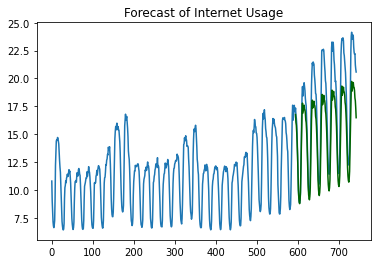

Mean Absolute Error (test): 2.349695594298912
R squared (test): 0.6294977689472165




In [10]:
# initialise statistical model object
object_sarima = StatisticalModel( train_values, test_values, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=24,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
# perfom SARIMA modelling
object_sarima.model_arima()
# print model summary
print(object_sarima)
# make predictions on a test dataset
predictions = object_sarima.make_prediction(len(test_values))
# plot the actual vs the predicted values
object_sarima.plot_predicted_actual_values()
# print metrics of the model
object_sarima.print_metrics()

The predicted values with SARIMA are definetely an improvement from ARIMA. However, during the last period of December the model cannot reach the high peaks. Potenitally something happened during the last period of the dataset.

Future steps:
 - Class is not entirely complete due to time restrictions
  - No docstring for all functions etc.
  - No validation for inputs